In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential  # sequence of layers (output of one layer is input to next)
from tensorflow.keras.layers import Input, Dense # 'dense' layer type that's fully connected to previous layer
from tensorflow.keras.optimizers import Adam # we could use a stochastic gradient descent optimizer as well
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

In [2]:
dfTrain = pd.read_csv('content/dataTrain.csv')
dfTest = pd.read_csv('content/dataTest.csv')
pciat_cols = dfTrain.columns[dfTrain.columns.str.contains('PCIAT-PCIAT')]

# drop id since we can't directly use that as a feature
dfTrain = dfTrain.drop(columns=['id'])
dfTest = dfTest.drop(columns=['id'])

Xtrain = dfTrain.drop(columns=pciat_cols.union(['sii']))
Xtest = dfTest.drop(columns=pciat_cols.union(['sii']))
ytrain = dfTrain[['sii']]
ytest = dfTest[['sii']]

feature_count = Xtrain.shape[1]

## Tensorflow version

In [34]:
model = Sequential()

model.add(Input(shape=(feature_count,)))
model.add(Dense(4, activation='relu',kernel_regularizer=regularizers.l2(0.01))) # lambda of 0.001
#model.add(Dropout(0.5))
model.add(Dense(3, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(Xtrain, ytrain, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                     │ (None, 4)                   │             340 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 3)                   │              15 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 359 (1.40 KB)

 Trainable params: 359 (1.40 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.7643 - val_loss: 0.6311
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5909 - val_loss: 0.6013
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5609 - val_loss: 0.5767
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5515 - val_loss: 0.5619
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5351 - val_loss: 0.5497
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5285 - val_loss: 0.5421
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4891 - val_loss: 0.5380
Epoch 8/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5208 - val_loss: 0.5298
Epoch 9/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4966 - val_loss: 0.5261
Epoch 10/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5142 - val_loss: 0.5243
Epoch 11/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4932 - val_loss: 0.5257
Epoch 12/100
143/143 ━━━━━━━━━━━━━━━━━━━━

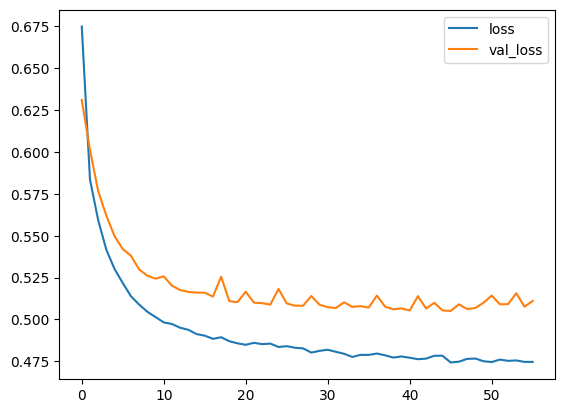

In [35]:
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='loss')
plt.plot(range(len(history.history['loss'])), history.history['val_loss'], label='val_loss')
plt.legend()

In [36]:
ytrainpred = model.predict(Xtrain)
ytestpred = model.predict(Xtest)
print("Train MSE ", mean_squared_error(ytrain, ytrainpred))
print("Test MSE ", mean_squared_error(ytest, ytestpred))

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Train MSE  0.45951345294355994
Test MSE  0.43871168004565575


## PyTorch version

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

In [6]:
# same neural net as above
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        
        self.layer1 = nn.Linear(input_size, 4)
        self.layer2 = nn.Linear(4, 3)
        self.layer3 = nn.Linear(3, 1)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [8]:
# Split the data into training, validation sets
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.2, random_state=42)

Xtrain_tensor = torch.tensor(Xtrain.values, dtype=torch.float32)
ytrain_tensor = torch.tensor(ytrain.values, dtype=torch.float32)
Xval_tensor = torch.tensor(Xval.values, dtype=torch.float32)
yval_tensor = torch.tensor(yval.values, dtype=torch.float32)
Xtest_tensor = torch.tensor(Xtest.values, dtype=torch.float32)
ytest_tensor = torch.tensor(ytest.values, dtype=torch.float32)

train_data = TensorDataset(Xtrain_tensor, ytrain_tensor)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

val_data = TensorDataset(Xval_tensor, yval_tensor)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

test_data = TensorDataset(Xtest_tensor, ytest_tensor)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

input_size = Xtrain.shape[1]
model = Net(input_size)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # L2 regularization via weight_decay
criterion = nn.MSELoss()

patience = 10
best_val_loss = float('inf')
patience_counter = 0

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, targets.view(-1, 1))  
        epoch_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    avg_epoch_loss = epoch_loss / len(train_loader)
    
    # Validation phase
    model.eval()  
    val_loss = 0.0
    with torch.no_grad(): 
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs)
            
            loss = criterion(val_outputs, val_targets.view(-1, 1)) 
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_epoch_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    
    # Early stopping logic based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

model.load_state_dict(torch.load('best_model.pth'))

# Evaluation on the test set (MSE)
model.eval()  

test_predictions = []
test_true = []

with torch.no_grad():  
    for test_inputs, test_targets in test_loader:
        test_outputs = model(test_inputs)
        
        test_predictions.append(test_outputs.numpy())  
        test_true.append(test_targets.numpy())  

test_predictions = np.concatenate(test_predictions, axis=0)
test_true = np.concatenate(test_true, axis=0)

mse_test = mean_squared_error(test_true, test_predictions)
print(f'Mean Squared Error on the Test Set: {mse_test:.4f}')

Epoch 1/100, Train Loss: 0.5827, Validation Loss: 0.4811
Epoch 2/100, Train Loss: 0.5067, Validation Loss: 0.4765
Epoch 3/100, Train Loss: 0.5033, Validation Loss: 0.4853
Epoch 4/100, Train Loss: 0.5011, Validation Loss: 0.4692
Epoch 5/100, Train Loss: 0.4934, Validation Loss: 0.4693
Epoch 6/100, Train Loss: 0.4891, Validation Loss: 0.4607
Epoch 7/100, Train Loss: 0.4854, Validation Loss: 0.4578
Epoch 8/100, Train Loss: 0.4778, Validation Loss: 0.4563
Epoch 9/100, Train Loss: 0.4747, Validation Loss: 0.4555
Epoch 10/100, Train Loss: 0.4688, Validation Loss: 0.4514
Epoch 11/100, Train Loss: 0.4662, Validation Loss: 0.4596
Epoch 12/100, Train Loss: 0.4678, Validation Loss: 0.4527
Epoch 13/100, Train Loss: 0.4629, Validation Loss: 0.4542
Epoch 14/100, Train Loss: 0.4612, Validation Loss: 0.4519
Epoch 15/100, Train Loss: 0.4577, Validation Loss: 0.4507
Epoch 16/100, Train Loss: 0.4559, Validation Loss: 0.4573
Epoch 17/100, Train Loss: 0.4574, Validation Loss: 0.4502
Epoch 18/100, Train Los